# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=512, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


     


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), (1024,1)]
    #cfg = [48, (96,2), 96, (192,2), 192, (384,2), 384, 384, 384, 384, 384, (768,2), (1024,1)]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, 512, 512, 512, 512,1024,1024]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        #print("X",out.shape)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1=open("Cifar10_INFO.txt","a+")
            f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-80)%10==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.306167, Accuracy: 11.13
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.245337, Accuracy: 15.82
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.002240, Accuracy: 18.75
Train Epoch: 0 [7680/50000 (17%)]	Loss: 1.920612, Accuracy: 29.49
Train Epoch: 0 [10240/50000 (23%)]	Loss: 1.909851, Accuracy: 26.95
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.836077, Accuracy: 29.10
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.738757, Accuracy: 32.42
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.705419, Accuracy: 36.91
Train Epoch: 0 [20480/50000 (45%)]	Loss: 1.719251, Accuracy: 32.42
Train Epoch: 0 [23040/50000 (51%)]	Loss: 1.638838, Accuracy: 38.28
Train Epoch: 0 [25600/50000 (57%)]	Loss: 1.660993, Accuracy: 38.48
Train Epoch: 0 [28160/50000 (62%)]	Loss: 1.592864, Accuracy: 42.77
Train Epoch: 0 [30720/50000 (68%)]	Loss: 1.655307, Accuracy: 39.26
Train Epoch: 0 [33280/50000 (74%)]	Loss: 1.577937, Accuracy: 41.21
Train Epoch: 0 [35840/50000 (80%)]	Loss: 1.564796, Accuracy: 42.19
Trai

Train Epoch: 6 [12800/50000 (28%)]	Loss: 0.521232, Accuracy: 81.45
Train Epoch: 6 [15360/50000 (34%)]	Loss: 0.610523, Accuracy: 77.54
Train Epoch: 6 [17920/50000 (40%)]	Loss: 0.550531, Accuracy: 82.62
Train Epoch: 6 [20480/50000 (45%)]	Loss: 0.613745, Accuracy: 79.88
Train Epoch: 6 [23040/50000 (51%)]	Loss: 0.645727, Accuracy: 76.56
Train Epoch: 6 [25600/50000 (57%)]	Loss: 0.597626, Accuracy: 77.54
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.600311, Accuracy: 79.30
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.592280, Accuracy: 79.88
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.589720, Accuracy: 79.49
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.611779, Accuracy: 78.91
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.589991, Accuracy: 79.88
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.516090, Accuracy: 81.25
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.587217, Accuracy: 79.10

Validation set: Average loss: 0.8366, Accuracy: 3592/5000 (71.00%)

the time of this epoch:[32.008793354034424 s]
Train Epoch: 7

Train Epoch: 12 [23040/50000 (51%)]	Loss: 0.396597, Accuracy: 85.16
Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.412639, Accuracy: 86.33
Train Epoch: 12 [28160/50000 (62%)]	Loss: 0.407177, Accuracy: 85.94
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.409256, Accuracy: 84.57
Train Epoch: 12 [33280/50000 (74%)]	Loss: 0.448723, Accuracy: 86.52
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.452364, Accuracy: 86.13
Train Epoch: 12 [38400/50000 (85%)]	Loss: 0.454056, Accuracy: 83.20
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.451189, Accuracy: 85.16
Train Epoch: 12 [43520/50000 (97%)]	Loss: 0.404137, Accuracy: 86.13

Validation set: Average loss: 0.6199, Accuracy: 3944/5000 (78.00%)

the time of this epoch:[31.918220043182373 s]
Train Epoch: 13 [0/50000 (0%)]	Loss: 0.332967, Accuracy: 88.87
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.407557, Accuracy: 87.11
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.427396, Accuracy: 84.96
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.358017, Accuracy: 87.30
Train Epoc

Train Epoch: 18 [33280/50000 (74%)]	Loss: 0.304386, Accuracy: 90.23
Train Epoch: 18 [35840/50000 (80%)]	Loss: 0.381645, Accuracy: 86.72
Train Epoch: 18 [38400/50000 (85%)]	Loss: 0.331379, Accuracy: 87.89
Train Epoch: 18 [40960/50000 (91%)]	Loss: 0.387664, Accuracy: 87.11
Train Epoch: 18 [43520/50000 (97%)]	Loss: 0.355058, Accuracy: 88.28

Validation set: Average loss: 0.6681, Accuracy: 3954/5000 (79.00%)

the time of this epoch:[31.966174840927124 s]
Train Epoch: 19 [0/50000 (0%)]	Loss: 0.319589, Accuracy: 89.45
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.229598, Accuracy: 92.97
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.306674, Accuracy: 89.06
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.290726, Accuracy: 89.65
Train Epoch: 19 [10240/50000 (23%)]	Loss: 0.326245, Accuracy: 89.26
Train Epoch: 19 [12800/50000 (28%)]	Loss: 0.295665, Accuracy: 90.04
Train Epoch: 19 [15360/50000 (34%)]	Loss: 0.296641, Accuracy: 89.65
Train Epoch: 19 [17920/50000 (40%)]	Loss: 0.252037, Accuracy: 91.21
Train Epoc

Train Epoch: 24 [40960/50000 (91%)]	Loss: 0.334549, Accuracy: 88.28
Train Epoch: 24 [43520/50000 (97%)]	Loss: 0.373092, Accuracy: 88.67

Validation set: Average loss: 0.5854, Accuracy: 4098/5000 (81.00%)

the time of this epoch:[31.945111989974976 s]
Train Epoch: 25 [0/50000 (0%)]	Loss: 0.316576, Accuracy: 89.26
Train Epoch: 25 [2560/50000 (6%)]	Loss: 0.258601, Accuracy: 91.41
Train Epoch: 25 [5120/50000 (11%)]	Loss: 0.223162, Accuracy: 91.21
Train Epoch: 25 [7680/50000 (17%)]	Loss: 0.227396, Accuracy: 91.41
Train Epoch: 25 [10240/50000 (23%)]	Loss: 0.272083, Accuracy: 89.45
Train Epoch: 25 [12800/50000 (28%)]	Loss: 0.242977, Accuracy: 90.82
Train Epoch: 25 [15360/50000 (34%)]	Loss: 0.242197, Accuracy: 91.80
Train Epoch: 25 [17920/50000 (40%)]	Loss: 0.264454, Accuracy: 90.82
Train Epoch: 25 [20480/50000 (45%)]	Loss: 0.295115, Accuracy: 89.45
Train Epoch: 25 [23040/50000 (51%)]	Loss: 0.242316, Accuracy: 90.43
Train Epoch: 25 [25600/50000 (57%)]	Loss: 0.226614, Accuracy: 91.80
Train Epoc


Test set: Average loss: 0.9644, Accuracy: 7281/10000 (72.81%)

Train Epoch: 31 [0/50000 (0%)]	Loss: 0.195188, Accuracy: 92.38
Train Epoch: 31 [2560/50000 (6%)]	Loss: 0.282287, Accuracy: 89.45
Train Epoch: 31 [5120/50000 (11%)]	Loss: 0.207655, Accuracy: 92.77
Train Epoch: 31 [7680/50000 (17%)]	Loss: 0.250315, Accuracy: 90.62
Train Epoch: 31 [10240/50000 (23%)]	Loss: 0.252349, Accuracy: 91.60
Train Epoch: 31 [12800/50000 (28%)]	Loss: 0.250948, Accuracy: 89.84
Train Epoch: 31 [15360/50000 (34%)]	Loss: 0.218918, Accuracy: 92.77
Train Epoch: 31 [17920/50000 (40%)]	Loss: 0.257302, Accuracy: 92.38
Train Epoch: 31 [20480/50000 (45%)]	Loss: 0.208586, Accuracy: 92.38
Train Epoch: 31 [23040/50000 (51%)]	Loss: 0.238801, Accuracy: 91.41
Train Epoch: 31 [25600/50000 (57%)]	Loss: 0.260393, Accuracy: 90.43
Train Epoch: 31 [28160/50000 (62%)]	Loss: 0.184658, Accuracy: 93.36
Train Epoch: 31 [30720/50000 (68%)]	Loss: 0.267797, Accuracy: 90.23
Train Epoch: 31 [33280/50000 (74%)]	Loss: 0.235676, Accuracy:

Train Epoch: 37 [7680/50000 (17%)]	Loss: 0.194885, Accuracy: 92.97
Train Epoch: 37 [10240/50000 (23%)]	Loss: 0.197278, Accuracy: 93.36
Train Epoch: 37 [12800/50000 (28%)]	Loss: 0.196741, Accuracy: 93.75
Train Epoch: 37 [15360/50000 (34%)]	Loss: 0.179015, Accuracy: 93.16
Train Epoch: 37 [17920/50000 (40%)]	Loss: 0.218397, Accuracy: 91.80
Train Epoch: 37 [20480/50000 (45%)]	Loss: 0.239521, Accuracy: 91.41
Train Epoch: 37 [23040/50000 (51%)]	Loss: 0.239885, Accuracy: 91.41
Train Epoch: 37 [25600/50000 (57%)]	Loss: 0.222160, Accuracy: 93.75
Train Epoch: 37 [28160/50000 (62%)]	Loss: 0.280757, Accuracy: 91.60
Train Epoch: 37 [30720/50000 (68%)]	Loss: 0.260755, Accuracy: 91.60
Train Epoch: 37 [33280/50000 (74%)]	Loss: 0.269348, Accuracy: 91.60
Train Epoch: 37 [35840/50000 (80%)]	Loss: 0.231633, Accuracy: 92.58
Train Epoch: 37 [38400/50000 (85%)]	Loss: 0.251120, Accuracy: 91.99
Train Epoch: 37 [40960/50000 (91%)]	Loss: 0.225812, Accuracy: 91.99
Train Epoch: 37 [43520/50000 (97%)]	Loss: 0.23930

Train Epoch: 43 [15360/50000 (34%)]	Loss: 0.154777, Accuracy: 94.92
Train Epoch: 43 [17920/50000 (40%)]	Loss: 0.232700, Accuracy: 91.99
Train Epoch: 43 [20480/50000 (45%)]	Loss: 0.176577, Accuracy: 93.55
Train Epoch: 43 [23040/50000 (51%)]	Loss: 0.262957, Accuracy: 91.21
Train Epoch: 43 [25600/50000 (57%)]	Loss: 0.207749, Accuracy: 91.99
Train Epoch: 43 [28160/50000 (62%)]	Loss: 0.176856, Accuracy: 94.14
Train Epoch: 43 [30720/50000 (68%)]	Loss: 0.201519, Accuracy: 92.97
Train Epoch: 43 [33280/50000 (74%)]	Loss: 0.269576, Accuracy: 90.62
Train Epoch: 43 [35840/50000 (80%)]	Loss: 0.226121, Accuracy: 93.55
Train Epoch: 43 [38400/50000 (85%)]	Loss: 0.226355, Accuracy: 92.38
Train Epoch: 43 [40960/50000 (91%)]	Loss: 0.246693, Accuracy: 90.23
Train Epoch: 43 [43520/50000 (97%)]	Loss: 0.263022, Accuracy: 91.60

Validation set: Average loss: 0.5280, Accuracy: 4164/5000 (83.00%)

the time of this epoch:[31.81550407409668 s]
Train Epoch: 44 [0/50000 (0%)]	Loss: 0.191246, Accuracy: 94.73
Train E

Train Epoch: 49 [25600/50000 (57%)]	Loss: 0.210752, Accuracy: 92.38
Train Epoch: 49 [28160/50000 (62%)]	Loss: 0.179645, Accuracy: 92.77
Train Epoch: 49 [30720/50000 (68%)]	Loss: 0.167353, Accuracy: 94.73
Train Epoch: 49 [33280/50000 (74%)]	Loss: 0.197970, Accuracy: 92.97
Train Epoch: 49 [35840/50000 (80%)]	Loss: 0.214395, Accuracy: 92.58
Train Epoch: 49 [38400/50000 (85%)]	Loss: 0.181011, Accuracy: 94.14
Train Epoch: 49 [40960/50000 (91%)]	Loss: 0.222110, Accuracy: 92.77
Train Epoch: 49 [43520/50000 (97%)]	Loss: 0.218021, Accuracy: 92.19

Validation set: Average loss: 0.4010, Accuracy: 4355/5000 (87.00%)

the time of this epoch:[31.870155811309814 s]
Train Epoch: 50 [0/50000 (0%)]	Loss: 0.167321, Accuracy: 93.36
Train Epoch: 50 [2560/50000 (6%)]	Loss: 0.171832, Accuracy: 93.75
Train Epoch: 50 [5120/50000 (11%)]	Loss: 0.204243, Accuracy: 93.75
Train Epoch: 50 [7680/50000 (17%)]	Loss: 0.153236, Accuracy: 94.73
Train Epoch: 50 [10240/50000 (23%)]	Loss: 0.253704, Accuracy: 92.19
Train Epoc

Train Epoch: 55 [33280/50000 (74%)]	Loss: 0.033153, Accuracy: 99.22
Train Epoch: 55 [35840/50000 (80%)]	Loss: 0.038170, Accuracy: 98.63
Train Epoch: 55 [38400/50000 (85%)]	Loss: 0.029350, Accuracy: 99.22
Train Epoch: 55 [40960/50000 (91%)]	Loss: 0.043037, Accuracy: 98.63
Train Epoch: 55 [43520/50000 (97%)]	Loss: 0.050667, Accuracy: 98.63

Validation set: Average loss: 0.2803, Accuracy: 4587/5000 (91.00%)

the time of this epoch:[31.890355110168457 s]
Train Epoch: 56 [0/50000 (0%)]	Loss: 0.028129, Accuracy: 99.22
Train Epoch: 56 [2560/50000 (6%)]	Loss: 0.044252, Accuracy: 98.24
Train Epoch: 56 [5120/50000 (11%)]	Loss: 0.030254, Accuracy: 99.22
Train Epoch: 56 [7680/50000 (17%)]	Loss: 0.043271, Accuracy: 98.24
Train Epoch: 56 [10240/50000 (23%)]	Loss: 0.043688, Accuracy: 98.63
Train Epoch: 56 [12800/50000 (28%)]	Loss: 0.035817, Accuracy: 99.22
Train Epoch: 56 [15360/50000 (34%)]	Loss: 0.054183, Accuracy: 98.24
Train Epoch: 56 [17920/50000 (40%)]	Loss: 0.024871, Accuracy: 99.22
Train Epoc

Train Epoch: 61 [40960/50000 (91%)]	Loss: 0.022495, Accuracy: 99.61
Train Epoch: 61 [43520/50000 (97%)]	Loss: 0.013847, Accuracy: 99.61

Validation set: Average loss: 0.3041, Accuracy: 4590/5000 (91.00%)

the time of this epoch:[34.59139609336853 s]
Train Epoch: 62 [0/50000 (0%)]	Loss: 0.009718, Accuracy: 99.80
Train Epoch: 62 [2560/50000 (6%)]	Loss: 0.025357, Accuracy: 99.22
Train Epoch: 62 [5120/50000 (11%)]	Loss: 0.034591, Accuracy: 98.83
Train Epoch: 62 [7680/50000 (17%)]	Loss: 0.015285, Accuracy: 100.00
Train Epoch: 62 [10240/50000 (23%)]	Loss: 0.015687, Accuracy: 99.61
Train Epoch: 62 [12800/50000 (28%)]	Loss: 0.036441, Accuracy: 98.83
Train Epoch: 62 [15360/50000 (34%)]	Loss: 0.011437, Accuracy: 99.80
Train Epoch: 62 [17920/50000 (40%)]	Loss: 0.030392, Accuracy: 99.02
Train Epoch: 62 [20480/50000 (45%)]	Loss: 0.016163, Accuracy: 99.61
Train Epoch: 62 [23040/50000 (51%)]	Loss: 0.014697, Accuracy: 99.61
Train Epoch: 62 [25600/50000 (57%)]	Loss: 0.024563, Accuracy: 99.22
Train Epoc

Train Epoch: 68 [0/50000 (0%)]	Loss: 0.006392, Accuracy: 100.00
Train Epoch: 68 [2560/50000 (6%)]	Loss: 0.013243, Accuracy: 99.61
Train Epoch: 68 [5120/50000 (11%)]	Loss: 0.014775, Accuracy: 99.61
Train Epoch: 68 [7680/50000 (17%)]	Loss: 0.009070, Accuracy: 99.80
Train Epoch: 68 [10240/50000 (23%)]	Loss: 0.013973, Accuracy: 99.61
Train Epoch: 68 [12800/50000 (28%)]	Loss: 0.014380, Accuracy: 99.80
Train Epoch: 68 [15360/50000 (34%)]	Loss: 0.017955, Accuracy: 99.61
Train Epoch: 68 [17920/50000 (40%)]	Loss: 0.018862, Accuracy: 99.61
Train Epoch: 68 [20480/50000 (45%)]	Loss: 0.009530, Accuracy: 100.00
Train Epoch: 68 [23040/50000 (51%)]	Loss: 0.015307, Accuracy: 99.41
Train Epoch: 68 [25600/50000 (57%)]	Loss: 0.021045, Accuracy: 99.41
Train Epoch: 68 [28160/50000 (62%)]	Loss: 0.006532, Accuracy: 99.80
Train Epoch: 68 [30720/50000 (68%)]	Loss: 0.014151, Accuracy: 99.41
Train Epoch: 68 [33280/50000 (74%)]	Loss: 0.009619, Accuracy: 99.80
Train Epoch: 68 [35840/50000 (80%)]	Loss: 0.021078, Acc

Train Epoch: 74 [5120/50000 (11%)]	Loss: 0.006067, Accuracy: 100.00
Train Epoch: 74 [7680/50000 (17%)]	Loss: 0.006529, Accuracy: 100.00
Train Epoch: 74 [10240/50000 (23%)]	Loss: 0.003618, Accuracy: 100.00
Train Epoch: 74 [12800/50000 (28%)]	Loss: 0.007458, Accuracy: 100.00
Train Epoch: 74 [15360/50000 (34%)]	Loss: 0.018816, Accuracy: 99.41
Train Epoch: 74 [17920/50000 (40%)]	Loss: 0.013427, Accuracy: 99.41
Train Epoch: 74 [20480/50000 (45%)]	Loss: 0.004422, Accuracy: 100.00
Train Epoch: 74 [23040/50000 (51%)]	Loss: 0.004524, Accuracy: 100.00
Train Epoch: 74 [25600/50000 (57%)]	Loss: 0.019389, Accuracy: 99.61
Train Epoch: 74 [28160/50000 (62%)]	Loss: 0.007836, Accuracy: 100.00
Train Epoch: 74 [30720/50000 (68%)]	Loss: 0.016405, Accuracy: 99.61
Train Epoch: 74 [33280/50000 (74%)]	Loss: 0.005930, Accuracy: 99.80
Train Epoch: 74 [35840/50000 (80%)]	Loss: 0.008565, Accuracy: 99.80
Train Epoch: 74 [38400/50000 (85%)]	Loss: 0.005027, Accuracy: 99.80
Train Epoch: 74 [40960/50000 (91%)]	Loss: 0

# Step 3: Test

In [ ]:
test(epoch)

## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

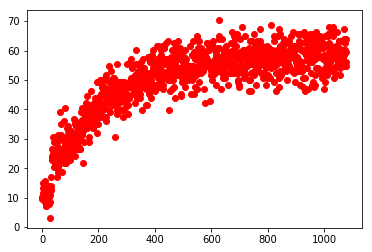

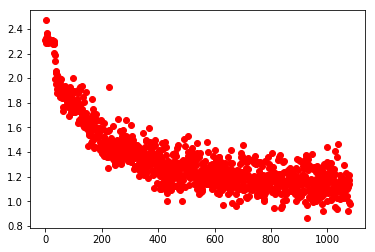

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

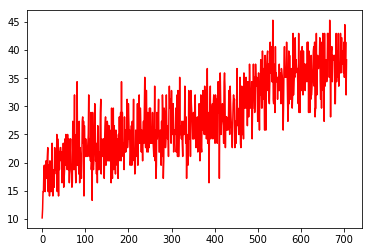

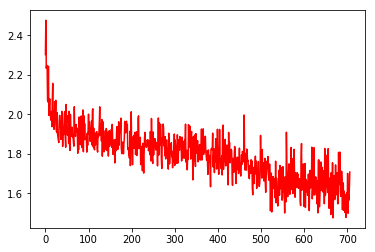

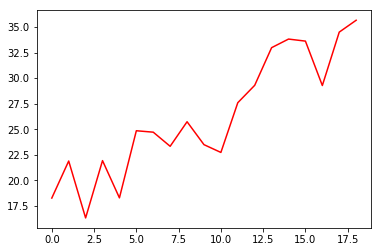

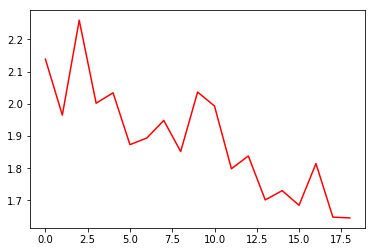

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()